Group 2

Members:

Naveen Gupta - 17CH30054

Harsh Choudhary - 17CH30040

Shivang Gupta - 17CS10050

Project Name: Nursery School Application Selection using Decision Tree-based Learning Mode

Project Code: NSDT

### Import Statements

In [ ]:
!pip install print-tree2

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
import operator
import math
from collections import Counter
from statistics import mean
from print_tree import print_tree

###for cross validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, StratifiedKFold

### Data Loading and Preprocessing

In [ ]:
df_train = pd.read_csv('nursery.csv',engine='python')
df_test = pd.read_csv('nursery_test.csv',engine='python')
print(df_train.head())

       parents     has_nurs        form  ...        �social       health       class
0   great_pret    very_crit    complete  ...        nonprob  recommended  spec_prior
1   great_pret  less_proper   completed  ...  slightly_prob     priority  spec_prior
2  pretentious  less_proper    complete  ...    problematic  recommended    priority
3  pretentious    very_crit  incomplete  ...        nonprob     priority  spec_prior
4        usual       proper      foster  ...  slightly_prob  recommended    priority

[5 rows x 9 columns]


In [ ]:
print(df_train.isnull().sum())

parents      0
 has_nurs    0
form         0
�children    0
�housing     0
�finance     0
�social      0
health       0
class        0
dtype: int64


In [ ]:
print(df_test.isnull().sum())

parents      0
 has_nurs    0
form         0
�children    0
�housing     0
�finance     0
�social      0
health       0
class        0
dtype: int64


In [ ]:
print("Shape of train data:",df_train.shape)
print("Shape of test data:",df_test.shape)

Shape of train data: (9998, 9)
Shape of test data: (2962, 9)


In [ ]:
print("Coulumns in train data:",df_train.columns)
print("Coulumns in test data:",df_test.columns)

Coulumns in train data: Index(['parents', ' has_nurs', 'form', '�children', '�housing', '�finance',
       '�social', 'health', 'class'],
      dtype='object')
Coulumns in test data: Index(['parents', ' has_nurs', 'form', '�children', '�housing', '�finance',
       '�social', 'health', 'class'],
      dtype='object')


In [ ]:
print("[INFO...]")
print("Train data....")
for col in list(df_train.columns):
    print("df_train[{}] => unique values are : {}".format(col, df_train[col].unique()))
    #sns.countplot(df[col])
    #plt.show()
print("\nTest data....")
for col in list(df_test.columns):
    print("df_test[{}] => unique values are : {}".format(col, df_test[col].unique()))

[INFO...]
Train data....
df_train[parents] => unique values are : ['great_pret' 'pretentious' 'usual']
df_train[ has_nurs] => unique values are : ['very_crit' 'less_proper' 'proper' 'improper' 'critical']
df_train[form] => unique values are : ['complete' 'completed' 'incomplete' 'foster']
df_train[�children] => unique values are : ['3' 'more' '2' '1']
df_train[�housing] => unique values are : ['less_conv' 'convenient' 'critical']
df_train[�finance] => unique values are : ['convenient' 'inconv']
df_train[�social] => unique values are : ['nonprob' 'slightly_prob' 'problematic']
df_train[health] => unique values are : ['recommended' 'priority' 'not_recom']
df_train[class] => unique values are : ['spec_prior' 'priority' 'not_recom' 'very_recom' 'recommend']

Test data....
df_test[parents] => unique values are : ['usual' 'great_pret' 'pretentious']
df_test[ has_nurs] => unique values are : ['very_crit' 'less_proper' 'improper' 'proper' 'critical']
df_test[form] => unique values are : ['comp

In [ ]:
## Preparing data for training
x, y = df_train.iloc[:, :-1].values, df_train.iloc[:, -1:].values
x_testdata, y_testdata = df_test.iloc[:, :-1].values, df_test.iloc[:, -1:].values
#y = y.reshape(-1, 1)

In [ ]:
print("shape of x is:",x.shape)

shape of x is: (9998, 8)


In [ ]:
print("shape of y is:",y.shape)

shape of y is: (9998, 1)


In [ ]:
x_train_cpy = x.copy()
x_test_cpy = x_testdata.copy()
y_train_cpy=y.copy()
y_test_cpy=y_testdata.copy()

In [ ]:
### Label Encoder for converting string into numberical data
encoder = dict()
for i in range(x.shape[1]):
    encoder[i] = LabelEncoder()
    encoder[i].fit(x_train_cpy[:, i])
    x_train_cpy[:, i] = encoder[i].transform(x_train_cpy[:, i])
    x_test_cpy[:, i] = encoder[i].transform(x_test_cpy[:, i])
encoder['y'] = LabelEncoder()
encoder['y'].fit(y_train_cpy[:, 0])
y_train_cpy = encoder['y'].transform(y_train_cpy[:, 0])
y_test_cpy = encoder['y'].transform(y_test_cpy[:, 0])

### Utility Functions

In [ ]:
## Class for TreeNode structure
class TreeNode(object):
    def __init__(self, name, val, data, index):
        self.node_name = name
        self.node_val = val
        self.data = data
        self.index = index
        self.child = dict()
    def add_child(self, key, val):
        self.child[key] = val

In [ ]:
## Class for for printing Decision tree
class print_custom_tree(print_tree):
    def get_children(self, node):
        x = []
        if node is None:
            return x
        for k in node.child.values():
            x.append(k)
        return x
    def get_node_str(self, node):
        if node.node_val=='y':
            return str(node.node_name)+'('+str(node.data[0])+','+str(len(node.data))+')'
        return str(node.node_name)

In [ ]:
# To get number of leaf nodes
def get_total_leaf_node(tree_node):
    if tree_node is None:
        return 0
    if tree_node.node_val=='y':
        return 1
    t = 0
    for val in tree_node.child.values():
        t += get_total_leaf_node(val)
    return t

### Task 1(a): Simple Decision Tree

In [ ]:
## Class for simple decision tree
class SimpleDecisionTreeClassifier():
    def __init__(self, method='gini'):
        self.root_node = None
        self.method = method
        self.data = None
        self.max_depth = 0
        self.total_leaf_node = 0

    ## To calculate entropy
    def entropy(self, y):
        freq_map = dict(Counter(y))
        if (len(set(y))==0):
            return None
        if(len(set(y))==1):
            return 0
        total_ent = 0
        l = len(y)
        for item in freq_map.values():
            pi = (item/l)
            total_ent += (-pi*math.log2(pi))

        return total_ent
        
    ## To calculate gini index
    def gini_index(self, y):
        freq_map = dict(Counter(y))
        if(len(set(y))==1):
            return 0
        if(len(set(y))==0):
            return None
        l = len(y)
        total_prob_sq = 0
        for item in freq_map.values():
            pi = (item/l)
            total_prob_sq += (pi*pi)
        return (1-total_prob_sq)

    ## To find the best split
    def best_split(self, data, level, feat_list, name):
        init_y = data['y']

        if self.method=='entropy':
            init_info_val = self.entropy(init_y)
        else:
            init_info_val = self.gini_index(init_y)
        
        if init_info_val is None:
            return 
        
        if(init_info_val==0):
            self.total_leaf_node+=1
            self.max_depth = max(self.max_depth, level)
            d = init_y.values
            return TreeNode(name, 'y', d, level)

        l = len(init_y)

        max_info_gain = 0
        split_node = None

        for feat in feat_list:
            feat_info_val = 0
            for feat_val in list(data[feat].unique()):
                new_data = data[data[feat]==feat_val]
                new_y = new_data['y']
                l_dash = len(new_y)
                if self.method=='entropy':
                    info_val = self.entropy(new_y)
                else:
                    info_val = self.gini_index(new_y)
                if(info_val is None):
                    continue
                feat_info_val += (l_dash*info_val/l)
            curr_info_gain = init_info_val - feat_info_val
            if(curr_info_gain>max_info_gain):
                max_info_gain = curr_info_gain
                split_node = feat

        if(split_node is None):
            return 

        new_feat_list = feat_list.copy()
        new_feat_list.remove(split_node)

        if(self.root_node is None):
            self.root_node = TreeNode(name, split_node, init_y.values, level)
            for feat_val in list(data[split_node].unique()):
                new_data = data[data[split_node]==feat_val]
                self.root_node.add_child(feat_val, self.best_split(new_data, level+1, new_feat_list, feat_val))

            return self.root_node

        new_node = TreeNode(name, split_node, init_y.values, level)
        for feat_val in list(data[split_node].unique()):
            new_data = data[data[split_node]==feat_val]
            new_node.add_child(feat_val, self.best_split(new_data, level+1, new_feat_list, feat_val))

        return new_node

    ## To fit the decision tree
    def fit(self, x, y):
        
        x = np.array(x)
        y = np.array(y)
        try:
            assert (len(x.shape)==2)
        except AssertionError:
            print("Invalid input. X should be of shape: (None, n_features)")
            return None
        try:
            assert (len(y.shape)==2)
        except AssertionError:
            print("Invalid input. Y should be of shape: (None, 1)")
            return None

        d = dict()
        l = x.shape[-1]
        for i in range(l):
            d[str(i)] = x[:,i]
        
        feat_list = list(d.keys())

        d['y'] = y[:, 0]
        data = pd.DataFrame(d)
        self.data = data

        self.best_split(data,0, feat_list, 'root')
        return self.root_node 

    ## To predict on test data
    def predictor(self, x, tree_node):
        if tree_node.node_name is None:
            return None
        if tree_node.node_val=='y':
            return tree_node.data[0]
        new_node = tree_node
        col_num = int(new_node.node_val)
        
        new_temp_node = new_node.child.get(x[col_num], None)
        if new_temp_node is None:
            ind = np.random.randint(0, len(self.data['y']))
            return self.data['y'][ind]
        ans = self.predictor(x, new_node.child[x[col_num]])
        return ans

    def predict(self, x):
        l = len(x)
        x = np.array(x)
        assert (len(x.shape)==2)
        res = []
        for i in range(l):
            y_val = self.predictor(x[i], self.root_node) 
            res.append(y_val)    
        return res      

### Task 1(a): Gini Method

In [ ]:
## Creating an instance of simple decision tree
simple_cf = SimpleDecisionTreeClassifier(method='gini')

In [ ]:
## Fitting the tree on the training data
simple_cf.fit(x,y)

In [ ]:
## Predict on test data
y_pred_gini = simple_cf.predict(x_testdata)

In [ ]:
#classification report on test data using simple decision tree classifier model with gini method
print(classification_report(y_testdata, y_pred_gini))

              precision    recall  f1-score   support

   not_recom       0.99      1.00      0.99       962
    priority       0.97      0.97      0.97       965
  spec_prior       0.98      0.98      0.98       949
  very_recom       0.82      0.71      0.76        86

    accuracy                           0.98      2962
   macro avg       0.94      0.91      0.93      2962
weighted avg       0.97      0.98      0.97      2962



In [ ]:
simple_gini_acc = accuracy_score(y_testdata, y_pred_gini)
print("Classification accuracy on test data using pruned decision tree model:{}%".format(round(simple_gini_acc*100, 2)))

Classification accuracy on test data using pruned decision tree model:97.54%


In [ ]:
print("Max depth of Decision tree is:", simple_cf.max_depth)
print("Total numbers of leaf nodes are:", simple_cf.total_leaf_node)

Max depth of Decision tree is: 8
Total numbers of leaf nodes are: 701


In [ ]:
## Printing the decision tree
print_custom_tree(simple_cf.root_node)


                                    ┌3(spec_prior,54)
                                    │ ┌foster(spec_prior,13)
                                    │ │         ┌problematic(spec_prior,5)
                                    │ ├completed┼slightly_prob(priority,5)
                                    │ │         └nonprob(priority,6)
                                    ├2┤
                                    │ ├incomplete(spec_prior,17)
                                    │ │        ┌problematic(spec_prior,5)
                                    │ └complete┼slightly_prob(priority,3)
                                    │          └nonprob(priority,4)
                          ┌less_conv┤
                          │         │ ┌problematic(spec_prior,20)
                          │         │ │             ┌foster(spec_prior,5)
                          │         │ │             ├incomplete(priority,5)
                          │         ├1┼slightly_prob┤
                          │         

### Task 1(a): Entropy method

In [ ]:
## Creating an instance of simple decision
simple_cf_ent = SimpleDecisionTreeClassifier(method='entropy')

In [ ]:
## Fitting the tree on the training data
simple_cf_ent.fit(x, y)

In [ ]:
## Predict on test data
y_pred_ent = simple_cf_ent.predict(x_testdata)

In [ ]:
#classification report on test data using simple decision tree classifier model with entropy method
print("Classification Report :")
print(classification_report(y_testdata, y_pred_ent))

Classification Report :
              precision    recall  f1-score   support

   not_recom       0.99      1.00      0.99       962
    priority       0.96      0.97      0.96       965
  spec_prior       0.98      0.97      0.97       949
  very_recom       0.84      0.76      0.80        86

    accuracy                           0.97      2962
   macro avg       0.94      0.92      0.93      2962
weighted avg       0.97      0.97      0.97      2962



In [ ]:
simple_ent_acc = accuracy_score(y_testdata, y_pred_ent)
print("Classification accuacy on test data using pruned decision tree model:{}%".format(round(simple_ent_acc*100, 2)))

Classification accuacy on test data using pruned decision tree model:97.23%


In [ ]:
print("Max depth of Decision tree is:", simple_cf_ent.max_depth)
print("Total numbers of leaf nodes are:", simple_cf_ent.total_leaf_node)

Max depth of Decision tree is: 8
Total numbers of leaf nodes are: 738


In [ ]:
## Printing the decision tree
print_custom_tree(simple_cf_ent.root_node)


                                            ┌3(spec_prior,16)
                                            │ ┌foster(spec_prior,5)
                                            │ ├completed(priority,5)
                                            ├1┤
                                            │ ├incomplete(priority,6)
                                            │ └complete(priority,5)
                                  ┌less_conv┤
                                  │         │ ┌incomplete(spec_prior,6)
                                  │         │ ├completed(priority,6)
                                  │         ├2┤
                                  │         │ ├complete(priority,4)
                                  │         │ └foster(spec_prior,4)
                                  │         └more(spec_prior,18)
                                  │        ┌more(spec_prior,21)
                                  │        ├3(spec_prior,19)
                          ┌nonprob┼critical┤
        

### Task 1(b) sklearn Testing

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
sk_clf = DecisionTreeClassifier(criterion='entropy')
## Fitting the tree on training data
sk_clf.fit(x_train_cpy, y_train_cpy)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
## Predicting on test data
y_pred_cpy = sk_clf.predict(x_test_cpy)

In [ ]:
## Using inverse transform to get back the classes
y_pred_cpy = encoder['y'].inverse_transform(y_pred_cpy)
y_test_cpy = encoder['y'].inverse_transform(y_test_cpy)

In [ ]:
print("Classification report :")
print(classification_report(y_test_cpy, y_pred_cpy))

Classification report :
              precision    recall  f1-score   support

   not_recom       1.00      1.00      1.00       962
    priority       0.99      0.99      0.99       965
   recommend       0.00      0.00      0.00         0
  spec_prior       0.99      0.99      0.99       949
  very_recom       0.98      0.94      0.96        86

    accuracy                           0.99      2962
   macro avg       0.79      0.79      0.79      2962
weighted avg       0.99      0.99      0.99      2962



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sklearn_acc = accuracy_score(y_test_cpy, y_pred_cpy)
print("Classification accuacy on test data using pruned decision tree model:{}%".format(round(sklearn_acc*100, 2)))

Classification accuacy on test data using pruned decision tree model:99.32%


### Task 2: Reduced error pruning

In [ ]:
# Class for pruned decision tree
class PrunedDecisionTreeClassifier():
    def __init__(self, method='gini'):
        self.root_node = None
        self.method = method
        self.data = None
        #self.max_depth = 0
        #self.total_leaf_node = 0
        
    ## To check if node is leaf node
    def is_leaf_node(self, node):
        if(node is None):
            return False
        if node.node_val=='y':
            return True
        return False

    ## To calculate entropy
    def entropy(self, y):
        freq_map = dict(Counter(y))
        if len(set(y))==0:
            return None
        if len(set(y))==1:
            return 0
        total_ent = 0
        l = len(y)
        for item in freq_map.values():
            pi = (item/l)
            total_ent += (-pi*math.log2(pi))

        return total_ent

    ## To calculate gini index
    def gini_index(self, y):
        freq_map = dict(Counter(y))
        if(len(set(y))==1):
            return 0
        if(len(set(y))==0):
            return None
        l = len(y)
        total_prob_sq = 0
        for item in freq_map.values():
            pi = (item/l)
            total_prob_sq += (pi*pi)
        return (1-total_prob_sq)

    ## To find the best split
    def best_split(self, data, level, feat_list, name):
        init_y = data['y']

        if self.method=='entropy':
            init_info_val = self.entropy(init_y)
        else:
            init_info_val = self.gini_index(init_y)
            
        if (init_info_val is None):
            return 
        if(init_info_val==0):
            #self.total_leaf_node+=1
            #self.max_depth = max(self.max_depth, level)
            d = init_y.values
            return TreeNode(name, 'y', d, level)

        l = len(init_y)

        max_info_gain = 0
        split_node = None
        

        for feat in feat_list:
            feat_info_val = 0
            for feat_val in list(data[feat].unique()):
                new_data = data[data[feat]==feat_val]
                new_y = new_data['y']
                l_dash = len(new_y)
                if self.method=='entropy':
                    info_val = self.entropy(new_y)
                else:
                    info_val = self.gini_index(new_y)
                if info_val is None:
                    continue
                feat_info_val += (l_dash*info_val/l)
            curr_info_gain = init_info_val - feat_info_val
            if(curr_info_gain>max_info_gain):
                max_info_gain = curr_info_gain
                split_node = feat

        if(split_node is None):
            return 

        new_feat_list = feat_list.copy()
        new_feat_list.remove(split_node)

        if(self.root_node is None):
            self.root_node = TreeNode(name, split_node, init_y.values, level)
            #print(self.root.node_name)
            for feat_val in list(data[split_node].unique()):
                new_data = data[data[split_node]==feat_val]
                self.root_node.add_child(feat_val, self.best_split(new_data, level+1, new_feat_list, feat_val))

            return self.root_node

        new_node = TreeNode(name, split_node, init_y.values, level)
        for feat_val in list(data[split_node].unique()):
            new_data = data[data[split_node]==feat_val]
            new_node.add_child(feat_val, self.best_split(new_data, level+1, new_feat_list, feat_val))

        return new_node

    ## Fitting the data on tree
    def fit(self, x, y):
        x = np.array(x)
        y = np.array(y)
        try:
            assert (len(x.shape)==2)
        except AssertionError:
            print("Invalid input. X should be of shape: (None, n_features)")
            return None
        try:
            assert (len(y.shape)==2)
        except AssertionError:
            print("Invalid input. Y should be of shape: (None, 1)")
            return None

        d = dict()
        l = x.shape[-1]
        for i in range(l):
            d[str(i)] = x[:,i]
        
        feat_list = list(d.keys())

        d['y'] = y[:, 0]
        data = pd.DataFrame(d)
        self.data = data
        #print(data.head())
        #print(feat_list)

        self.best_split(data,0, feat_list, 'root')
        return self.root_node 

    def predictor(self, x, tree_node):
        if tree_node is None:
            return None
        if tree_node.node_val=='y':
            return tree_node.data[0]
        new_node = tree_node
        col_num = int(new_node.node_val)
        
        new_temp_node = new_node.child.get(x[col_num], None)
        if new_temp_node is None:
            ind = np.random.randint(0, len(self.data['y']))
            return self.data['y'][ind]
        ans = self.predictor(x, new_node.child[x[col_num]])
        return ans

    def predict(self, x):
        l = len(x)
        x = np.array(x)
        assert (len(x.shape)==2)
        res = []
        for i in range(l):
            y_val = self.predictor(x[i], self.root_node) 
            res.append(y_val)    
        return res  
    
    def accuracy_metric(self, true, predicted):
        l = len(true)
        score = 0
        for i in range(l):
            if(true[i]==predicted[i]):
                score += 1
        return (score*100/l)

    def get_prune_error(self, major_class, y):
        error = 0
        l = len(y)
        if(l==0):
            return 0
        for i in range(l):
            if y[i]!=major_class:
                error+=1
        return error/l
    def get_major_class(self,y):
        x = dict(Counter(y))
        major_class = sorted(x, reverse=True, key=x.get)[0]
        return major_class
        
    ## To prune the decision tree 
    def prune(self, tree_node, test_data, ):
        if tree_node is None:
            return tree_node
        if self.is_leaf_node(tree_node):
            return tree_node
        
        flag = True
        col = tree_node.node_val
        
        for key, val in tree_node.child.items():
            #print(key, val.node_name)
            new_test_data = test_data[test_data[col]==key]
            tree_node.child[key] = self.prune(val, new_test_data)
            if not self.is_leaf_node(tree_node.child[key]):
                flag = False
                
        if flag:
            parent_major_class = self.get_major_class(tree_node.data)
            parent_error = self.get_prune_error(parent_major_class,test_data['y'].values)
            
            total_child_error = 0
            l = len(test_data)
            if(l==0):
                return tree_node
            
            for key, val in tree_node.child.items():
                new_test_data = test_data[test_data[col]==key]
                l_dash = len(new_test_data)
                child_major_class = self.get_major_class(tree_node.child[key].data)
                child_error = self.get_prune_error(child_major_class, new_test_data['y'].values)
                total_child_error += (child_error*l_dash/l)
            #print("total_child_error:",total_child_error)
            #print("parent_error:",parent_error)
            child_nodes_len = len(tree_node.child.keys())
            #print_custom_tree(tree_node)
            #print("##########################")
            
            if(parent_error<=total_child_error):
                new_node = TreeNode(parent_major_class, 'y', tree_node.data, tree_node.index)
                return new_node
            
            return tree_node
            
            
        return tree_node
    
    def pruning(self, x_test, y_test):
        d = dict()
        l = x_test.shape[-1]
        for i in range(l):
            d[str(i)] = x_test[:,i]
        d['y'] = y_test[:, 0]
        
        test_data = pd.DataFrame(d)
        
        return self.prune(self.root_node, test_data)  

### Task 2(a): Validation Data set extraction

In [ ]:
## Splitting the train data set 
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=42, test_size=0.1)

###Task 2(b): KFold cross validation and pruning

In [ ]:
## Initializing Kfold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
def accuracy(y_true, y_pred):
    total_accuracy = 0
    l = len(y_true)
    for i in range(l):
        if(y_true[i]==y_pred[i]):
            total_accuracy += 1
    total_accuracy/=l
    #print(total_err*100,'%', sep='')
    return total_accuracy*100

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, shuffle=True, random_state=42)
#print(len(x_train))

In [ ]:
data_set_size = [10, 20, 50, 100, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 5000, 7500, len(x_train)]

In [ ]:
## Performance of decision tree with and without pruning
accuracy_without_pruning = []
accuracy_with_pruning = []
for sz in data_set_size:
    ind = np.random.randint(0, len(x_train), sz)
    x_loop = x_train[ind]
    y_loop = y_train[ind]
    #print("shape of x_loop: {}, shape of y_loop: {}".format(x_loop.shape, y_loop.shape))
    total_acc1 = 0
    total_acc2 = 0
    for train_index, test_index in kfold.split(x_loop, y_loop):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = x_loop[train_index], x_loop[test_index]
        Y_train, Y_test = y_loop[train_index], y_loop[test_index]
        
        prune_clf = PrunedDecisionTreeClassifier()
        prune_clf.fit(X_train, Y_train)
        
        Y_pred = prune_clf.predict(x_val)
        accuracy_before = accuracy(y_val, Y_pred)

        prune_clf.pruning(X_test, Y_test)

        Y_pred = prune_clf.predict(x_val)

        accuracy_after=accuracy(y_val, Y_pred)

        total_acc1 += accuracy_before
        total_acc2 += accuracy_after

    total_acc1/=10
    total_acc2/=10
    print("Average total_accuracy for training dataset size {} without pruning: {}%".format(sz,total_acc1))
    print("Average total_accuracy for training dataset size {} with pruning: {}%".format(sz,total_acc2))
    accuracy_without_pruning.append(total_acc1)
    accuracy_with_pruning.append(total_acc2)
    print("*******")
    

Average total_accuracy for training dataset size 10 without pruning: 61.629999999999995%
Average total_accuracy for training dataset size 10 with pruning: 61.92%
*******
Average total_accuracy for training dataset size 20 without pruning: 66.66000000000001%
Average total_accuracy for training dataset size 20 with pruning: 66.39000000000001%
*******
Average total_accuracy for training dataset size 50 without pruning: 77.21000000000001%
Average total_accuracy for training dataset size 50 with pruning: 78.29000000000002%
*******
Average total_accuracy for training dataset size 100 without pruning: 77.72000000000001%
Average total_accuracy for training dataset size 100 with pruning: 74.68999999999998%
*******
Average total_accuracy for training dataset size 200 without pruning: 76.03999999999999%
Average total_accuracy for training dataset size 200 with pruning: 75.25000000000001%
*******
Average total_accuracy for training dataset size 300 without pruning: 85.82%
Average total_accuracy fo

### Plotting the performances

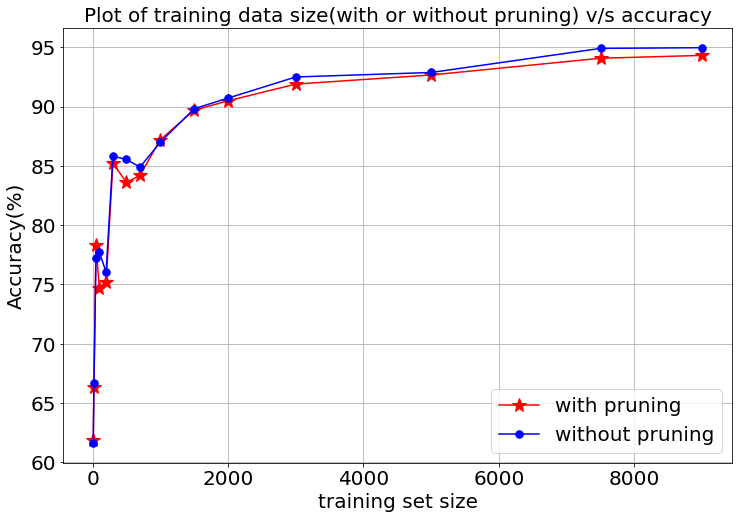

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=20) 

plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(data_set_size, accuracy_with_pruning, marker='*', ms=15, color='r', label='with pruning')
plt.plot(data_set_size, accuracy_without_pruning, marker='.', ms=15, color='b', label='without pruning')
plt.xlabel('training set size', size=20)
plt.ylabel('Accuracy(%)', size=20)
plt.legend()
#plt.xticks(data_set_size)
#plt.yticks(accuracy_list)
plt.title('Plot of training data size(with or without pruning) v/s accuracy', size=20)
plt.show()
plt.savefig('Result.png')

### Pruned tree on test data

In [ ]:
### Creating an instance of pruned decision tree
prune_clf = PrunedDecisionTreeClassifier()
prune_clf.fit(x_train, y_train)

In [ ]:
## Pruning the tree
prune_clf.pruning(x_val, y_val)
## Predicting on test data
y_pred = prune_clf.predict(x_testdata)

In [ ]:
#classification report on test data using pruned decision tree classifier model
print(classification_report(y_testdata, y_pred))

              precision    recall  f1-score   support

   not_recom       0.99      1.00      0.99       962
    priority       0.95      0.95      0.95       965
  spec_prior       0.98      0.96      0.97       949
  very_recom       0.73      0.72      0.73        86

    accuracy                           0.96      2962
   macro avg       0.91      0.91      0.91      2962
weighted avg       0.96      0.96      0.96      2962



In [ ]:
prune_acc = accuracy_score(y_testdata, y_pred)
print("Classification accuacy on test data using pruned decision tree model:{}%".format(round(prune_acc*100, 2)))

Classification accuacy on test data using pruned decision tree model:96.46%


In [ ]:
#print("Final Pruned Tree :")
#print_custom_tree(prune_clf.root_node)